# Pandas Basics: Discovery → Cleaning → Quick Transforms

**Goal:** practice fast exploratory wrangling on a messy tabular dataset using Pandas.

**You’ll do:**
- Inspect structure and types
- Quantify missingness
- Handle missing values (drop / fill / interpolate)
- Lightweight transforms (casting, renaming, grouping, joining)
- Quick validation & export

## 1. Setup
---
**Goal:** Prepare your environment and load a dataset into Pandas.

**Steps:**
1. Import libraries: `pandas as pd`, `numpy as np`
2. Load your CSV into a DataFrame (`df`)

In [2]:
import os, sys, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set paths
ROOT_ = os.getcwd()
DATA_  = os.path.join(ROOT_, "data")

# Obtain all CSV file paths in the data directory
csv_paths = glob.glob(os.path.join(DATA_, "*.csv*"))
assert len(csv_paths) > 0, f"No CSV files found in {DATA_}"

> 💡 "Data should be transformed as far upstream as possible, and as far downstream as necessary" - Matthew Roche, Microsoft

> Use `pd.read_csv(..., dtype=..., parse_dates=...)` to enforce schema at load time.



In [4]:
# Load non-comma delimited data
data_name = "semicolon"
path = [path for path in csv_paths if data_name in path][0]
df_semicolon_delim = pd.read_csv(path)
print(df_semicolon_delim.head())

     id;name;value
0  1;user_1;-0.989
1  2;user_2;-0.368
2   3;user_3;1.288
3   4;user_4;0.194
4    5;user_5;0.92


In [5]:
# Load compressed data
data_name = "compressed"
path = [path for path in csv_paths if data_name in path][0]
df_compressed = pd.read_csv(path)   # Works because compression='infer' by default
print(df_compressed.head())

          a   b
0  1.074031  47
1  0.392621   0
2  0.005114  88
3 -0.361767  75
4 -1.230232  95


In [6]:
# Load encoded data
data_name = "latin1"
path = [path for path in csv_paths if data_name in path][0]
df_encoded = pd.read_csv(path)
print(df_encoded.head())

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 11: invalid continuation byte

In [ ]:
# Load data with metadata rows
data_name = "metadata"
path = [path for path in csv_paths if data_name in path][0]
df_metadata = pd.read_csv(path, skiprows=2, header=0)
print(df_metadata.head())

  region quarter  revenue
0    NaN      Q1     1200
1     EU      Q2     1500


In [ ]:
# Load European date data
data_name = "dates1"
path = [path for path in csv_paths if data_name in path][0]
df_dayfirst = pd.read_csv(path)
print(df_dayfirst.head())

         date      time  value
0  31/12/2024  23:59:59      1
1  01/01/2025  00:00:01      2
2  15/02/2025  12:30:00      3


In [ ]:
# Load EU/US date data
data_name = "dates2"
path = [path for path in csv_paths if data_name in path][0]
df_dayfirst = pd.read_csv(path)
print(df_dayfirst.head(10))

# How do you decide if a number <= 12 is a month or a day?
# Without another column identifying region or prior information, we can't parse these correctly on read.

         date      time  value
0  31/12/2024  23:59:59      1
1  01/01/2025  00:00:01      2
2  15/02/2025  12:30:00      3
3  12/31/2024  10:10:10      4
4  01/15/2025  08:45:00      5
5  02/28/2025  14:20:30      6


## 2. Discovery & Data Exploration
---
**Goal:** Get a first impression of the dataset’s structure and contents.**

**Core Functions:**
- `df.head()`, `df.tail()` → peek at rows
- `df.sample(5)` → random check
- `df.shape`, `df.dtypes`, `df.columns` → structure overview
- `df.info()` → column types + non-null counts
- `df.describe(include='all')` → quick summary (numeric + categorical)
- `df['col'].value_counts(dropna=False)` → frequency counts

> 📝 *Exercise*: Identify 3 columns that look suspicious (weird types, strange ranges, inconsistent categories).

In [8]:
"""Generate dataset to work with"""
# Set random seed for reproducibility
rng = np.random.default_rng(42)


# Generate a dataset with 500 rows and 5 features
n = 500
age = rng.integers(15, 90, size=n).astype(float)  # numeric with some missing
income = rng.normal(50000, 15000, size=n)         # numeric with outliers
score = rng.uniform(0, 100, size=n)               # uniform, noise
signup_date = pd.date_range("2020-01-01", periods=n, freq="D")  # datetime
category = rng.choice(["A", "B", "C", None], size=n, p=[0.3, 0.3, 0.3, 0.1])  # categorical with NaNs

# Introduce missing values in age and income
age[rng.choice(n, 30, replace=False)] = np.nan
income[rng.choice(n, 20, replace=False)] = np.nan

# Add some extreme outliers in income
income[rng.choice(n, 5, replace=False)] = rng.normal(200000, 10000, size=5)

# Slightly corrupt score with negative and >100 values
score[rng.choice(n, 10, replace=False)] = rng.choice([-10, 150], size=10)

# Assemble DataFrame
df = pd.DataFrame({
    "age": age,
    "income": income,
    "score": score,
    "signup_date": signup_date,
    "category": category
})

# Save to CSV
df.to_csv(f"{DATA_}/trashy_dataset.csv", index=False)

# Load raw data
df_trashy_dataset = pd.read_csv(f"{DATA_}/trashy_dataset.csv")


In [9]:
# Print head and tail of the DataFrame
print(f"[DataFrame Head]\n")
print(df_trashy_dataset.head(10))

print(f"\n[DataFrame Tail]\n")
print(df_trashy_dataset.tail(10))

# Obtain a random sample from the DataFrame
print(f"\n[Random Sample of n Rows]\n")
print(df_trashy_dataset.sample(10))

[DataFrame Head]

    age        income       score signup_date category
0  21.0  48586.061686  150.000000  2020-01-01        B
1  73.0  23634.074130   59.019538  2020-01-02        B
2  64.0  27994.321319   84.943533  2020-01-03        B
3  47.0  81938.706680    0.474139  2020-01-04        A
4  47.0  30688.661281   85.336946  2020-01-05        B
5  79.0  33548.216323   61.911909  2020-01-06        A
6  21.0  77553.702925   16.274349  2020-01-07        A
7  67.0  93576.007539   77.293739  2020-01-08        C
8  30.0  32426.500568   85.549154  2020-01-09        B
9  22.0  44476.265648   25.426348  2020-01-10        B

[DataFrame Tail]

      age        income      score signup_date category
490  84.0  50874.114964  40.126496  2021-05-05        A
491  80.0  58231.082283  32.393667  2021-05-06        A
492  71.0  47184.935136  94.864550  2021-05-07        A
493  60.0  54172.155897  57.686096  2021-05-08        A
494  36.0  52371.786274  80.619097  2021-05-09        A
495  45.0  61666.51083

In [10]:
# View DataFrame shape, columns, and data types
print(f"\nDataFrame Shape: {df_trashy_dataset.shape}")
print(f"DataFrame Columns: {df_trashy_dataset.columns.tolist()}\n")
print(f"DataFrame Dtypes:\n {df_trashy_dataset.dtypes}")


DataFrame Shape: (500, 5)
DataFrame Columns: ['age', 'income', 'score', 'signup_date', 'category']

DataFrame Dtypes:
 age            float64
income         float64
score          float64
signup_date     object
category        object
dtype: object


In [11]:
# Print DataFrame info to see data types and non-null counts
print(f"\n[DataFrame Info]\n")
print(df_trashy_dataset.info())


[DataFrame Info]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          470 non-null    float64
 1   income       480 non-null    float64
 2   score        500 non-null    float64
 3   signup_date  500 non-null    object 
 4   category     441 non-null    object 
dtypes: float64(3), object(2)
memory usage: 19.7+ KB
None


In [12]:
# Generate summary statistics for all columns:
# - For numeric columns:            count, mean, std, min, quartiles (25%, 50%, 75%), max
# - For object/categorical columns: count, unique, top (most frequent), freq (frequency of top)
# - For datetime columns:           count, unique, top, freq, first, last
df_trashy_dataset.sort_values('signup_date').describe(include='all')

,age,income,score,signup_date,category
count,470.000000,480.000000,500.000000,500,441
unique,NaN,NaN,NaN,500,3
top,NaN,NaN,NaN,2021-05-14,B
freq,NaN,NaN,NaN,1,154
mean,52.453191,51417.370248,50.806593,NaN,NaN
std,21.437392,21421.247863,31.367464,NaN,NaN
min,15.000000,5532.067432,-10.000000,NaN,NaN
25%,35.000000,39906.180229,23.798984,NaN,NaN
50%,52.000000,50806.316997,49.458932,NaN,NaN
75%,71.000000,59994.056476,76.669091,NaN,NaN



Unique values in 'category' column:
category
B      154
A      145
C      142
NaN     59
Name: count, dtype: int64


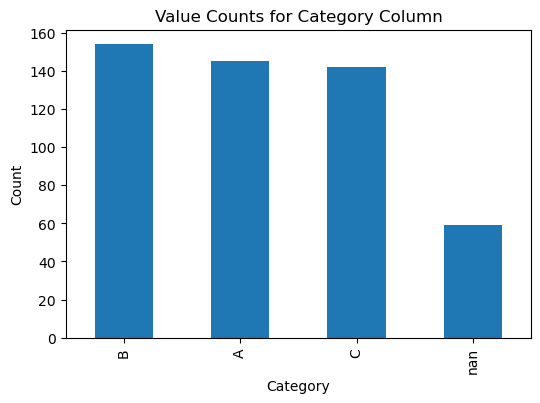

In [17]:
# Print unique values for a specific column and its value counts
column = 'category'
print(f"\nUnique values in 'category' column:\n{df_trashy_dataset[column].value_counts(dropna=False)}")

# Visualized
value_counts = df_trashy_dataset[column].value_counts(dropna=False)
if df_trashy_dataset[column].dtype == 'object':
    plt.figure(figsize=(6, 4))
    ax = value_counts.plot(kind='bar')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Value Counts for Category Column')
    plt.show()
else:
    plt.figure(figsize=(6, 4))
    ax = df_trashy_dataset[column].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column.capitalize()}')
    plt.show()

## 3. Missing Values
- Find: Count of missing values per column

**Strategies**
- Drop: `df.dropna(subset=[...])` when missingness is rare and random
- Fill constants: `df.fillna({'col': 0})`
- Fill by summary: mean/median/mode using `df['col'].fillna(df['col'].median())`
- Time-aware: `df['col'].interpolate(method='time')`
- Forward/backward fill for events/logs: `ffill`/`bfill`

> Exercise: create a small table showing before/after missingness for 3 columns.

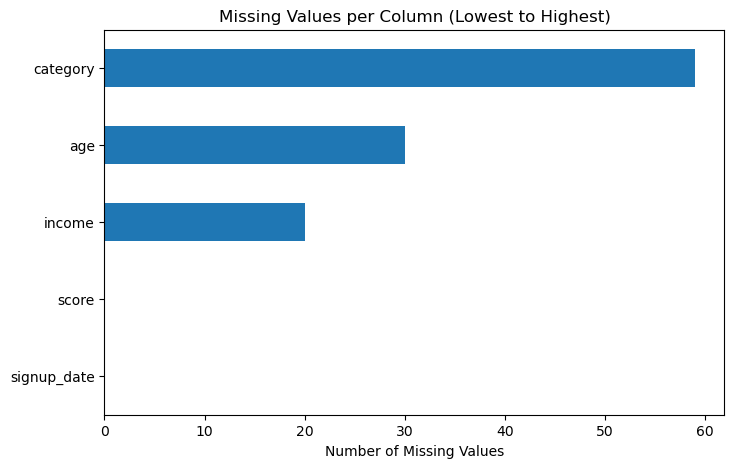

In [14]:
# Visualize missing values as a bar plot
missing_counts = df_trashy_dataset.isna().sum().sort_values()
plt.figure(figsize=(8, 5))
ax = missing_counts.plot(kind='barh')
plt.xlabel('Number of Missing Values')
plt.title('Missing Values per Column (Lowest to Highest)')
plt.show()

In [15]:
# Use dropna() to get rid of rows where any column is NaN/Null
df_dropna = df_trashy_dataset.copy()
df_dropna = df_dropna.dropna(how='any')

# View summary statistics
print(f'New Shape: {df_dropna.shape}\n')
df_dropna.info()

# Why do we still see indexes 0-499?

New Shape: (400, 5)

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          400 non-null    float64
 1   income       400 non-null    float64
 2   score        400 non-null    float64
 3   signup_date  400 non-null    object 
 4   category     400 non-null    object 
dtypes: float64(3), object(2)
memory usage: 18.8+ KB


In [ ]:
# Fill missing values with column means (numeric) or mode (categorical)
df_fillna = df_trashy_dataset.copy()
print(df_fillna.describe(include='all'), end='\n\n')


# Criteria for filling in missing values for each column:
for col in df_fillna.columns:
    if df_fillna[col].dtype in [np.float64, np.int64]:          # Numeric Columns - Fill with Mean
        mean_value = df_fillna[col].mean()
        df_fillna[col] = df_fillna[col].fillna(mean_value)
    elif df_fillna[col].dtype == 'object':                      # Categorical Columns - Fill with most frequent (mode)
        mode_value = df_fillna[col].mode()[0]
        df_fillna[col] = df_fillna[col].fillna(mode_value)
    elif np.issubdtype(df_fillna[col].dtype, np.datetime64):    # Datetime Columns - Fill with most frequent (mode)
        mode_value = df_fillna[col].mode()[0]
        df_fillna[col] = df_fillna[col].fillna(mode_value)

# View summary statistics
df_fillna.info()

# View DataFrame after filling missing values
df_fillna.loc[404]


               age         income       score signup_date category
count   470.000000     480.000000  500.000000         500      441
unique         NaN            NaN         NaN         500        3
top            NaN            NaN         NaN  2021-05-14        B
freq           NaN            NaN         NaN           1      154
mean     52.453191   51417.370248   50.806593         NaN      NaN
std      21.437392   21421.247863   31.367464         NaN      NaN
min      15.000000    5532.067432  -10.000000         NaN      NaN
25%      35.000000   39906.180229   23.798984         NaN      NaN
50%      52.000000   50806.316997   49.458932         NaN      NaN
75%      71.000000   59994.056476   76.669091         NaN      NaN
max      89.000000  214623.552635  150.000000         NaN      NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ag

age                    52.0
income         47869.951784
score             75.026599
signup_date      2021-02-08
category                  B
Name: 404, dtype: object

## 4. Quick Transformations
- Types: `df['col'] = df['col'].astype('Int64')`, `to_datetime`, `to_numeric(errors='coerce')`
- String cleanup: `str.strip()`, `str.lower()`, `str.replace()`
- Column ops: `rename`, `assign`, `eval`
- Split/merge: `merge`, `join`, `concat`
- Grouped summaries: `groupby(...).agg({'col':['count','mean','median']})`

> Exercise: normalize a numeric column to [0,1] using min-max, then compute per-group means.

In [ ]:
df_transformed = df_trashy_dataset.copy()



## 5. Validations (cheap but effective)
- Range checks: `(df['age']>=0) & (df['age']<=120)`
- Cross-field rules: if `end_time` then `end_time>=start_time`
- Uniqueness: `df['id'].is_unique`
- Duplicates: `df.duplicated(subset=[...], keep=False)` then review

> Exercise: write 3 boolean checks and compute the percent of rows failing each.

## 6. Export
- Save a clean slice: `df.to_parquet('clean.parquet', index=False)` or `to_csv`
- Document assumptions in a README cell or a sidecar `.md` file.

**Takeaways**
- Start with discovery, not modeling.
- Make missingness visible first, then pick the simplest plausible fix.
- Encode your checks so you can re-run them later.